# Lane detection Project

## important imports

In [1]:
import os
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sqlalchemy import true
%matplotlib inline

## 1. Compute the camera calibration sing chessboard images

### 1.1. Generate object points and image points

In [2]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob(r'camera_cal\calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    
    # Read in a calibration image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add objects points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

### 1.2. Compute the camera calibration given points and image points

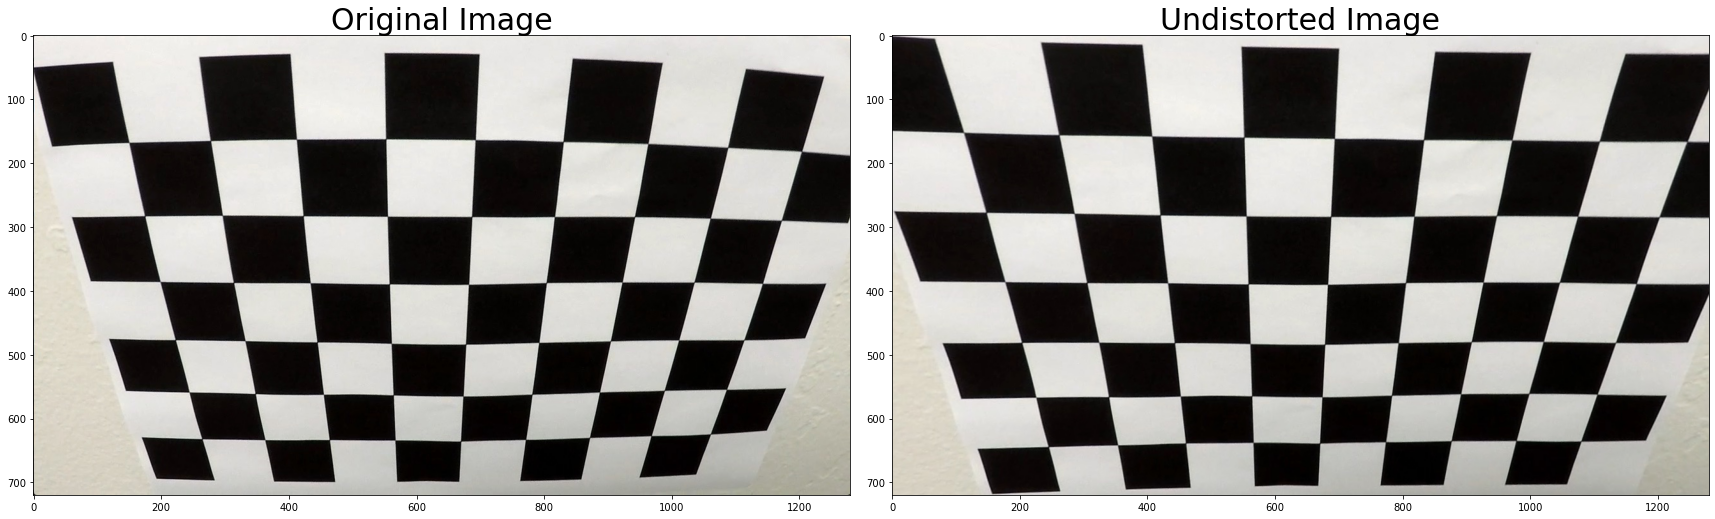

In [3]:
# Test undistortion on an image
img = mpimg.imread(r'camera_cal\calibration2.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

# Undistort a test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig(r'output_images\calibration.jpg')

### 1.3. Apply distortion correction to raw images

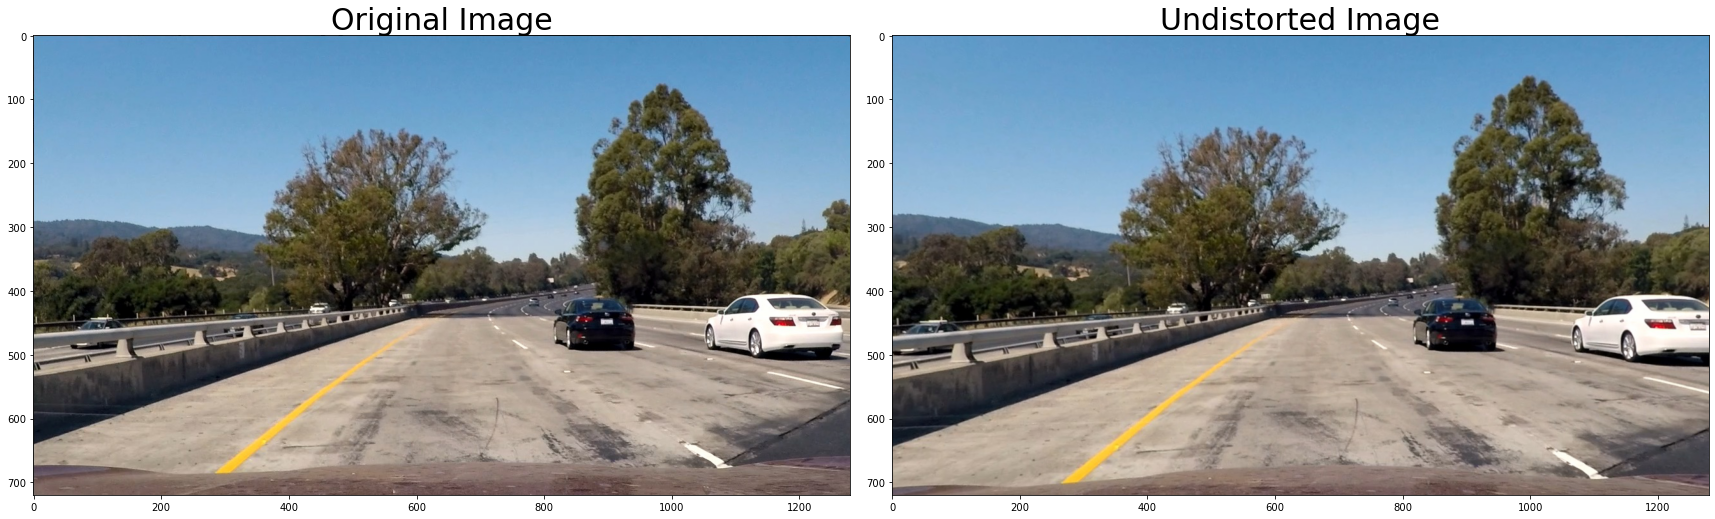

In [4]:
# Apply distortion correction to a raw image
img = mpimg.imread(r'test_images\test1.jpg')

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Undistort a raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig(r'output_images\distortion.jpg')

## 2. Create a thresholded binary image

### 2.1. Define function to get lane edges using color transformations 

In [5]:
def channel_thresh(img):
    # Convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # Convert image to HSV color space 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    V = hsv[:,:,2]
    # Threshold selected channel l to detect right lane
    L_max=np.amax(L)
    right_lane_photo = np.zeros_like(L)
    #Apply relative thresholds to the maximum value of channel L
    right_lane_photo[(L >= 0.8*L_max) & (L <= 1*L_max)] = 1
    left_lane_photo_h = np.zeros_like(H)
    #Apply the yellow color thershold to channel H to detect left lane
    left_lane_photo_h[(H >= 20) & (H <= 30)] = 1
    
    #Apply relative thresholds to the maximum value of channel V to detect left lane
    left_lane_photo_v = np.zeros_like(V)
    V_max=np.amax(V)
    left_lane_photo_v[(V >= 0.58*V_max) & (V <= 1*V_max)] = 1
    left_lane_photo = np.zeros_like(V)
    left_lane_photo=left_lane_photo_v&left_lane_photo_h
    
    # Create 2 binary channels for left & right lanes
    return left_lane_photo , right_lane_photo

### 2.2. Test `channel_thresh` with a single raw image

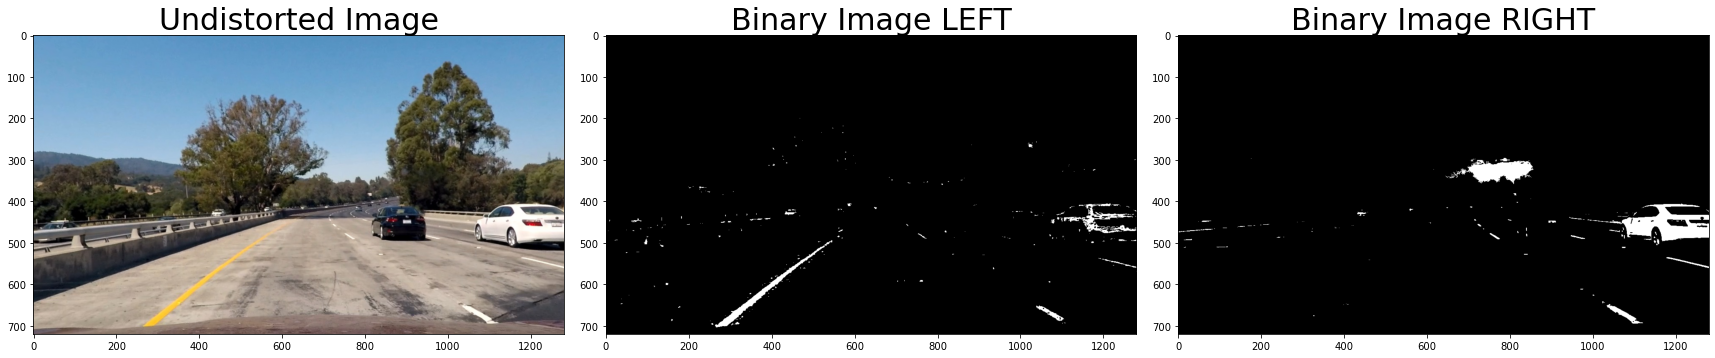

In [6]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Apply distortion correction to a raw image
img = mpimg.imread(r'test_images\test1.jpg')

# Undistort a raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Create a thresholded binary image
left_lane_edges,right_lane_edges = channel_thresh(dst)


# Visualize undistortion
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(left_lane_edges, cmap='gray')
ax2.set_title('Binary Image LEFT', fontsize=30)
ax3.imshow(right_lane_edges, cmap='gray')
ax3.set_title('Binary Image RIGHT', fontsize=30)
plt.savefig(r'output_images\binary.jpg')